# Numerical code generation from symbolic expressions in Python

#### Fabio Rossi
#### email: fabio.rossi@inaf.it
#### Github: https://github.com/FabioRossiArcetri

#### This work was developed in the context of the simulations for the MAVIS/VLT instrument

#### MAVIS simulations team @Arcetri: Cedric Plantet, Guido Agapito, Fabio Rossi
 - Thanks to the support and for providing the mathematical content!

##### “Astrobigné” presentation, Arcetri 06/10/2020

# Introduction

- Numpy/SciPy  are widely used in numerical codes, at different scales
- NumPy can be seen as an implementation on the CPU of the <b>“Array Programming”</b> paradigm:
    - https://www.nature.com/articles/s41586-020-2649-2#article-info
- Other implementations of the same paradigm have been developed (similar APIs, different backend) :
    - CuPy, GPU, based on NVIDIA CUDA
    - ClPy, GPU/CPU based on openCL
    - Tensorflow (GPU/CPU mainly used for Neural Networks development)

# Motivation
- What happens when you have to develop a numerical code?
    - Somewhere the math of the problem is stated, a bunch of expressions, functions, integrals, matrices etc
    - During the implementation phase, the needed math is embedded in the code in more or less clean/modular fashion
- Are the algorithms well apart from the mathematical definitions?
- How reusable is your code?
- Can you easily use the same expression in different algorithms?
- Could you run your code (or just its critical parts) on a GPU? How easily could you port it to use some library that allows it?

# Motivation

- Usually numerical codes are developed independently from symbolic functions definition
- SymPy is the Python library implementing symbolic computation
    - it is a CAS, Computer Algebra System like Mathematica, MathCad, Maple, but developed in Python and OpenSource
- Can we benefit by introducing symbolic expression definition and manipulation Numerical Code development cycle?
    - One initial step defining the symbolic functions
    - Symbolic functions can be manipulated in ways numerical functions can’t
    - Sympy Symbolic functions can be translated automatically to numerical functions: <b>"lambdify"</b>  mechanism
    - Easily import/export your math from/to other CAS softwares or languages (including LaTex)
- See appendix A for a 5 minutes introduction to SymPy

# Approach outline

![](Astrobigne2020.jpg)

# Software Stack
![](Astrobigne2020_2.jpg)

# SEEING: Sympy Expressions Evaluation Implemented oN the GPU

- Github Repo: https://github.com/FabioRossiArcetri/SEEING
    - feel free to checkout, experiment and give feedbacks
- Goals:
    - Factor out common tasks when using SymPy expressions as a starting point for numerical code development
    - Provide helper functions to handle groups of related SymPy expressions
        - evaluate, plot, substitute parameters, share variables
    - Provide a simple way to generate NumPy of CuPy code, so that you quickly evaluate expressions on the GPU
        - Immplement functions that are not provided by CuPy or NumPy but do exist in SymPy
    - Develop Backend agnostic Numerical Algorithms
        - use of xp.something calls (where xp can be numpy or cupy)
        - currently numpy and cupy are supported, in the future clpy or other numerical backends might be added
        - for now just a few Numerical Integration methods, over n-dimensional domains


# SEEING Overview

- Define a sympy function (or just load some formulas someone else saved to disk)
- Specialize some parameters
- Evaluate a function or an integral

In [1]:
from seeing import *
propMethodsCartesian = Formulary.loadFromFile('Propagation100.frm')
approximations = ["Rayleigh-Sommerfeld", "Approximate Rayleigh-Sommerfeld", "Near Fresnel"]
propMethodsCartesian.display(approximations)

Rayleigh-Sommerfeld


Eq(E_1(x_1, y_1, z_1), Integral(-I*E_0*z_1*(I*lambda*(1/(2*pi*sqrt(z_1**2 + (-x_0 + x_1)**2 + (-y_0 + y_1)**2))) + 1)*exp(2*I*pi*sqrt(z_1**2 + (-x_0 + x_1)**2 + (-y_0 + y_1)**2)/lambda)/(lambda*(z_1**2 + (-x_0 + x_1)**2 + (-y_0 + y_1)**2)), (x_0, -a, a), (y_0, -a, a)))

Approximate Rayleigh-Sommerfeld


Eq(E_1(x_1, y_1, z_1), Integral(-I*E_0*z_1*exp(2*I*pi*sqrt(z_1**2 + (-x_0 + x_1)**2 + (-y_0 + y_1)**2)/lambda)/(lambda*(z_1**2 + (-x_0 + x_1)**2 + (-y_0 + y_1)**2)), (x_0, -a, a), (y_0, -a, a)))

Near Fresnel


Eq(E_1(x_1, y_1, z_1), Integral(-I*E_0*exp(2*I*pi*z_1/lambda)*exp(I*pi*((-x_0 + x_1)**2 + (-y_0 + y_1)**2)/(lambda*z_1))/(lambda*z_1), (x_0, -a, a), (y_0, -a, a)))

In [2]:
propMethodsCartesian.display(["Rayleigh-Sommerfeld Arg"])

Rayleigh-Sommerfeld Arg


-I*E_0*z_1*(I*lambda*(1/(2*pi*sqrt(z_1**2 + (-x_0 + x_1)**2 + (-y_0 + y_1)**2))) + 1)*exp(2*I*pi*sqrt(z_1**2 + (-x_0 + x_1)**2 + (-y_0 + y_1)**2)/lambda)/(lambda*(z_1**2 + (-x_0 + x_1)**2 + (-y_0 + y_1)**2))

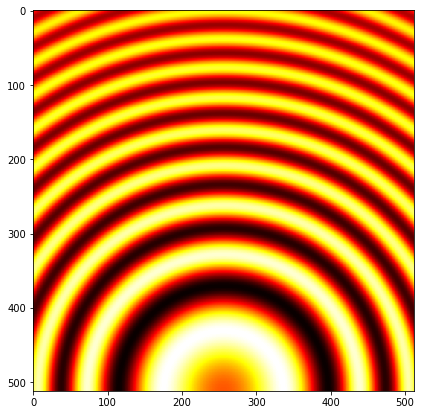

In [3]:
waveLength = 10e-6
apertureRadius =  waveLength*10
mCalc = Calculator(cp, cp.float64, 'intensity')
subdiv_points = 512
subsDictC = {'E_0': 1, 'z_1': 2*apertureRadius, 'x_0': 0, 'y_0': apertureRadius, 'lambda': waveLength, 'a':apertureRadius}
paramAndRanges = [( 'x_1', -apertureRadius, apertureRadius, subdiv_points, 'linear' ),
                  ( 'y_1', -apertureRadius, apertureRadius, subdiv_points, 'linear' )]
#xx, ez = propMethodsCartesian.evaluateFormula("Rayleigh-Sommerfeld Arg", subsDictC, paramAndRanges, mCalc)
#fig, ax = plt.subplots(figsize=(10,10))
#ax.imshow( np.real(ez), cmap='hot' )
propMethodsCartesian.plotFormula("Rayleigh-Sommerfeld Arg", subsDictC, paramAndRanges, mCalc)

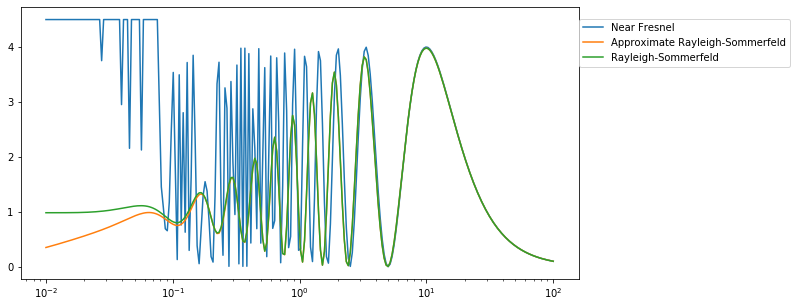

In [4]:
subdiv_points = 256
ez0_c =  subsParamsByName( propMethodsCartesian.getFormula('xyCircle'), {'a':apertureRadius} )
subsDictC = {'E_0': ez0_c, 'x_1': 0, 'y_1': 0, 'lambda': waveLength, 'a':apertureRadius}
paramAndRange = ( 'z_1', 0.01*apertureRadius, apertureRadius*100, subdiv_points, 'geometric' )
fig, ax = plt.subplots(figsize=(10,5))
plt.xscale('log')
plt.yscale('linear')
for appr in reversed(approximations):
    eeq = propMethodsCartesian.getFormula(appr)
    xplot2, zplot2 = mCalc.IntegralEvalE(subsParamsByName(eeq, subsDictC), [paramAndRange], None, 'trap')
    plt.plot(xplot2[0]/apertureRadius, np.clip(zplot2, -4.5, 4.5), label=appr)
plt.legend(loc=(1.0, 0.78))
plt.show()

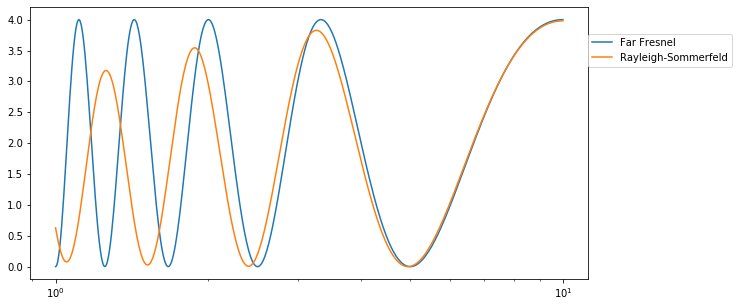

In [5]:
approximationsF = ["Rayleigh-Sommerfeld", "Far Fresnel"]
fig, ax = plt.subplots(figsize=(10,5))
plt.xscale('log')
plt.yscale('linear')
paramAndRange = ( 'z_1', apertureRadius, apertureRadius*10, 500, 'geometric' )
subsDictC = {'E_0': ez0_c, 'x_1': 0, 'y_1': 0, 'lambda': waveLength, 'a':apertureRadius}
for appr in reversed(approximationsF):
    eeq = propMethodsCartesian.getFormula(appr)
    xplot2, zplot2 = mCalc.IntegralEvalE(subsParamsByName(eeq, subsDictC), [paramAndRange], [(subdiv_points, 'linear'), (subdiv_points, 'linear')], 'rect')
    plt.plot(xplot2[0]/apertureRadius, np.clip(zplot2, -4.5, 4.5), label=appr)
plt.legend(loc=(1.0, 0.78))
plt.show()

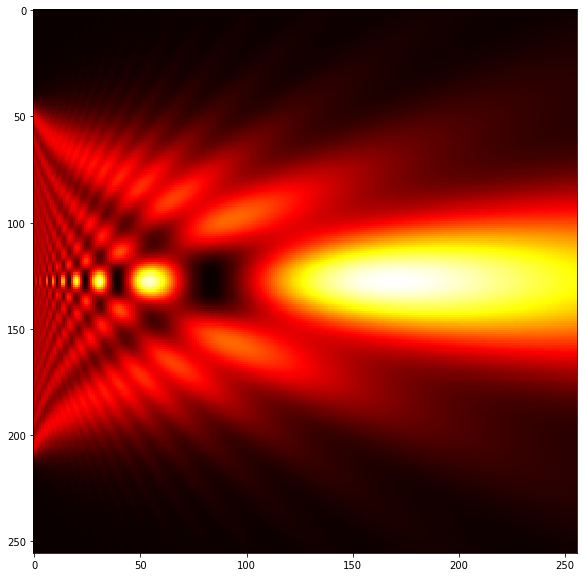

In [6]:
subdiv_points = 256
subsDict = {'E_0': ez0_c, 'y_1': 0, 'lambda': waveLength, 'a':apertureRadius}
paramsAndRanges = [ ('x_1', -1.5*apertureRadius, 1.5*apertureRadius, subdiv_points, 'linear'), ('z_1',  waveLength, 15*apertureRadius, subdiv_points, 'linear')]
eeq = propMethodsCartesian.getFormula("Rayleigh-Sommerfeld")
xplot, fplot1 = mCalc.IntegralEvalE(subsParamsByName(eeq, subsDict), paramsAndRanges) 
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow( fplot1, cmap='hot' )

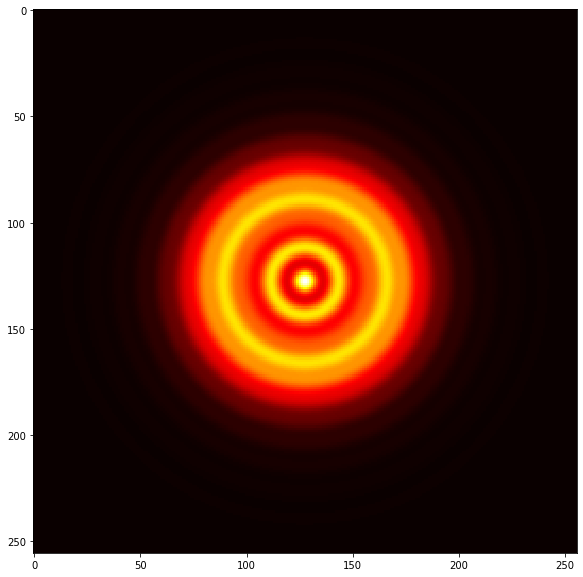

In [7]:
subsDict = {'E_0': ez0_c, 'z_1': 2*apertureRadius, 'lambda': waveLength, 'a':apertureRadius}
paramsAndRanges = [ ('x_1', -2*apertureRadius, 2*apertureRadius, subdiv_points, 'linear'), ('y_1', -2*apertureRadius, 2*apertureRadius, subdiv_points, 'linear')]
eeq = propMethodsCartesian.getFormula("Rayleigh-Sommerfeld")

xplot, fplot1 = mCalc.IntegralEvalE(subsParamsByName(eeq, subsDict), paramsAndRanges) 

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow( np.log(fplot1+1), cmap='hot' )

# Using SEEING for MAVIS Simulations

- We are using the approach described so far and the SEEING library to develop simulations related to the development of the MAVIS instrument for the VLT telescope
    - Development of a tool for Natural Guide Star asterism selection 
    - Synthetic PSF estimation (both for design purposes and observation planning/evaluation)
    
- Quite a lot, quite huge expressions!
- Example: Covariance of two Zernike Modes

In [8]:
from seeing import *
from zernike import *
mf = Formulary.loadFromFile('Mavis.frm')
mIt = Integrator(cp, cp.float64, 'none')
covIntegral = mf['ZernikeCovarianceI']
display(covIntegral)

Eq(W_phi(rho), Integral(0.0229*(-1)**m_k*2**((-0.5)*KroneckerDelta(0, m_j) - 0.5*KroneckerDelta(0, m_k) + 1)*I**(n_j + n_k)*sqrt((n_j + 1)*(n_k + 1))*(I**(3*m_j + 3*m_k)*cos(theta*(m_j + m_k) + pi*((1 - KroneckerDelta(0, m_j))*((-1)**j - 1) + (1 - KroneckerDelta(0, m_k))*((-1)**k - 1))/4)*besselj(m_j + m_k, 2*pi*f*h*rho) + I**(3*Abs(m_j - m_k))*cos(theta*(m_j - m_k) + pi*((1 - KroneckerDelta(0, m_j))*((-1)**j - 1) - (1 - KroneckerDelta(0, m_k))*((-1)**k - 1))/4)*besselj(Abs(m_j - m_k), 2*pi*f*h*rho))*besselj(n_j + 1, 2*pi*R_1*f)*besselj(n_j + 1, 2*pi*R_2*f)/((pi*R_1*R_2*f*r_0**(5/3)*((1/L_0)**2 + f**2)**(11/6))), (f, f_min, f_max)))

In [9]:
r0_Value = 0.15 # [m]
L0_Value = 25.0 # [m]
TelescopeDiameter = 8.0 #[m]
DM_height = 10000 # [m]
rho_max = 120.0/206265.0
paramsDict = {'f_min':0.001, 'f_max':10, 'theta': np.pi/4.0, 'L_0': L0_Value, 
              'r_0': r0_Value, 'R_1': TelescopeDiameter/2.0, 'R_2': TelescopeDiameter/2.0, 'h': DM_height }
_integral1 = subsParamsByName( cov_expr_jk(covIntegral, 2, 3), paramsDict)
display(_integral1)

Eq(W_phi(rho), Integral(-0.135193784634899*besselj(2, 8.0*pi*f)**2*besselj(2, 20000*pi*f*rho)/(pi*f*(f**2 + 0.0016)**(11/6)), (f, 0.001, 10)))

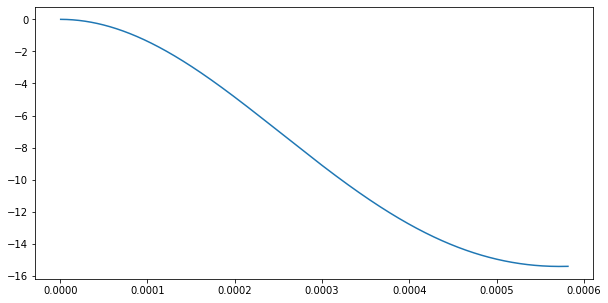

In [10]:
xplot1, zplot1 = mIt.IntegralEvalE(_integral1, [('rho',  0.0, rho_max, 1000, 'linear')], [(1024, 'linear')], method='rect')
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xplot1[0], zplot1)
plt.show()

# Sympy Lambdify

- Sympy provides the lambdify method to transform a sympy expression to a lambda which is also a composition of ufuncs, for different backends ("math", "mpmath", "numpy", "numexpr", "scipy" etc)
- What about a CuPy? 
- We can pass to lambdify a dictionary which maps sympy functions to cupy functions
- The dictionary will include many obvious translations like: gpulib = { ... 'sin': cp.sin … 

In [11]:
import inspect
from seeing import *

x = sp.symbols('x')
fsympy = sp.sin(x) * sp.exp(x) / (1+sp.sqrt(sp.Abs(x)) ) 
display(fsympy)
fnumpy = sp.lambdify(x, fsympy, "numpy" )
print(inspect.getsource(fnumpy))
print(fnumpy.__globals__['sin'])
fcupy = sp.lambdify(x, fsympy, gpulib )
print(inspect.getsource(fcupy))
print(fcupy.__globals__['sin'])

exp(x)*sin(x)/(sqrt(Abs(x)) + 1)

def _lambdifygenerated(x):
    return (exp(x)*sin(x)/(sqrt(abs(x)) + 1))

<ufunc 'sin'>
def _lambdifygenerated(x):
    return (exp(x)*sin(x)/(sqrt(abs(x)) + 1))

<ufunc 'cupy_sin'>


# Problem

- What about SymPy functions which do not have a CuPy analogue?
    - i.e. CuPy only provides the Bessel Functions of the first order of index 0 and 1... but we can implent and use in the lambdify process our own version for general n

In [12]:
# somewhere we defined:
def besselj__n(n, z):
    if n==0:
        return cupyx.scipy.special.j0(z)
    elif n==1:
        return cupyx.scipy.special.j1(z)
    elif n>=2:
        return 2*besselj__n(n-1, z)/z - besselj__n(int(n)-2, z)

# and in gpulib dictionary we have: ... 'besselj: 'besselj__n' ... 

In [13]:
from seeing import *

n = sp.symbols('n', integer=True)
fsympy = sp.besselj(n, x)
display(fsympy)
fnumpy = sp.lambdify((x, n), fsympy, "scipy" )
print(inspect.getsource(fnumpy))
print(fnumpy.__globals__['jv'])
fcupy = sp.lambdify((x,n), fsympy, gpulib )
print(inspect.getsource(fcupy))
print(fcupy.__globals__['besselj'])

besselj(n, x)

def _lambdifygenerated(x, n):
    return (jv(n, x))

<ufunc 'jv'>
def _lambdifygenerated(x, n):
    return (besselj(n, x))

<function besselj__n at 0x7f3592a5f598>


# This is interesting, now what?
- Read the reminder of this presentation, including the Appendixes
- Refresh your NumPy skills (ufuncs, array programming)
    - remember: loops are bad !!!
- Start using SymPy: don’t need to become an expert, just need to able to define your expressions/functions
- Understand basic concepts of GPU programming by experimenting with CuPy: if you know NumPy it’s going to be almost straightforward
- “SEEING” library could help you to easily manipulate/lambdify/evaluate your math on CPU/GPU
# Be relieved! You don’t need to learn C/C++ and CUDA if you don't want to!

# More details about NumPy, Cupy, Sympy and the development of SEEING

# Array programming

- Do as much as possible using Numpy built-in functions and avoid loops and element-wise access
  - understand what ufuncs are
  - See Appeindix C for a glimpse of performance gains
- Performances: Python-like vs C-like !
- Simplyfied transition to different backends (i.e. CuPy)
- Crucial for GPU programming

# What is a ufunc

- A (basic) ufunc in NumPy (or CuPy) is a function that can be applied to vectors, working an element-wise basis. 
    - for example: np.sin, np.cos, np.power
    - np.meshgrid() is not!
    - np.sum() is a reduction ufunc...
    - more details here: https://numpy.org/doc/stable/reference/ufuncs.html

# Array programming on the GPU with CuPy

- CuPy API tries to be as similar as possible to NumPy's, https://docs.cupy.dev/en/stable/
- Comparison table of the two libraries: https://docs.cupy.dev/en/stable/reference/comparison.html
- Important issue to take care of: CPU<->GPU data transfer
    - if the data set you are performing your computation on is quite small, depending on how complex is your computations, it might get less efficient to transfer it to the GPU and get the result back than simply perform your computation on the CPU
- For a 5 minutes introduction to CuPy see Appendix B

# What is a lambda?

- A lambda is just a (usually small) anonymous function:

In [14]:
f = lambda a,b,c : a+b*c
print(f(5, 6, 2))

17


In [15]:
# also useful when you want to do have a function that returns a function:
def myfunc(n):
    return lambda a:a*n

mydoubler = myfunc(2)
print(mydoubler(11))

22


# Adding some functionalities to SymPy
- When manipulating an expression imported from another module, we would like an easy way to access its symbols, symbols' names

In [16]:
# lets say we have this function returning a SymPy expression defined somewhere
def niceExpr():
    x0, y0, ss = sp.symbols('x_0 y_0 sigma')
    return sp.exp(-x0/ss) + sp.log(1+sp.Abs(y0)*ss)

# then in out main program we could have:
anExpr=niceExpr()
display(anExpr)

log(sigma*Abs(y_0) + 1) + exp(-x_0/sigma)

- just looking at the expression, we can tell there is a parameter named sigma
- we would like to substitute it with some specific real value, how to do it?
- we might not have an easy way to access to the 'ss' variable!!!

In [17]:
print(anExpr.free_symbols)
# cannot do this: ss = anExpr.free_symbols[1]

# we can do this:
ss = sp.symbols('sigma')
anExprSpec = anExpr.subs(ss, 0.5)
display(anExprSpec)

# ugly, what if sigma was complex?

{y_0, x_0, sigma}


log(0.5*Abs(y_0) + 1) + exp(-2.0*x_0)

- We want to have group of formulas sharing the same symbols, this is not obviosly done in SymPy
- We want to implement numerical algorithms that can have in input SymPy expressions and run relying on NumPy or CuPy (same algorithm AND code, different backend)
    - Think about a Monte Carlo integration method that can work using calls like:
        - sp.lambdify(integrand_functions, xp), xp.sum(), xp.random.uniform() etc etc, where xp is a variable point to either np or cp

# Appendix A: 5 minutes intro to Sympy

- Define some symbols
- Define a function
- .. or an integral
- Specialize
- Evaluate

In [18]:
import sympy as sp

#Define some symbols
x, y, a, b = sp.symbols("x y a b")
# Define a function
f1 = sp.exp(-a*x**2-b*y**2)
# see how nicely it is displayed
display(f1)

exp(-a*x**2 - b*y**2)

In [19]:
# Or define an integral
i1 = sp.Integral(f1, (x,-sp.oo,+sp.oo), (y,-sp.oo,+sp.oo))
display(i1)

Integral(exp(-a*x**2 - b*y**2), (x, -oo, oo), (y, -oo, oo))

In [20]:
# Specialize
i2 = i1.subs([(a, 1), (b,2)])
# Evaluate
display(i2.doit())

sqrt(2)*pi/2

In [21]:
#You could also do real symbolic computations… : 
fdev = sp.diff(f1, y) 
display(fdev)

-2*b*y*exp(-a*x**2 - b*y**2)

# Appendix B: 5 minutes intro to CuPy
### How to:
- Allocate an array, compose and use some ufuncs
- Move data from the CPU to the GPU
- Move data from the GPU to the CPU

In [22]:
import numpy as np
import cupy as cp

npoints = int(1e6)
fcpu = lambda x : np.sum( np.sin(x) * np.exp(x) / (1+np.sqrt(np.abs(x)) ) ) / npoints
x_cpu = np.linspace(-1.0, 1.0, npoints)
result = fcpu(x_cpu) 
print(type(result), result)

x_gpu = cp.linspace(-1.0, 1.0, npoints)
fgpu = lambda x : cp.sum( cp.sin(x) * cp.exp(x) / (1+cp.sqrt(cp.abs(x)) ) ) / npoints
result = fgpu(x_gpu)
print(type(result), result)

<class 'numpy.float64'> 0.17955110645016475
<class 'cupy.core.core.ndarray'> 0.1795511064501647


In [23]:
x_cpu = np.array([1,2,3])
print(type(x_cpu), x_cpu)
x_gpu = cp.asarray(x_cpu)  # move the data to the current device.
print(type(x_gpu), x_gpu)

<class 'numpy.ndarray'> [1 2 3]
<class 'cupy.core.core.ndarray'> [1 2 3]


In [24]:
x_gpu = cp.array([1, 2, 3])  # create an array in the current device
print(type(x_gpu), x_gpu)
x_cpu = cp.asnumpy(x_gpu)  # move the array to the host.
print(type(x_cpu), x_cpu)

<class 'cupy.core.core.ndarray'> [1 2 3]
<class 'numpy.ndarray'> [1 2 3]


# Appendix C: Performance comparison: Python vs NumPy vs Cupy

In [25]:
import numpy as np
import cupy as cp
import math

def mySquaredSum(xx):
    r = 0.0
    for i in range(xx.shape[0]):
        r += xx[i]*xx[i]*math.exp(x[i])*math.sin(x[i])**3
    return r

npoints = int(1e5)

x_gpu = cp.linspace(0, 1, npoints)
x = np.linspace(0, 1, npoints)
print(mySquaredSum(x))

26717.919072457928


In [26]:
f = lambda x: np.sum(np.square(x)*np.exp(x)*np.sin(x)**3)
print(f(x))

26717.919072458004


In [27]:
fgpu = lambda x: cp.sum(cp.square(x)*cp.exp(x)*cp.sin(x)**3)
print(fgpu(x_gpu))

26717.919072458


In [28]:
%%timeit
y = mySquaredSum(x)

156 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
y = f(x)

9.27 ms ± 5.23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%%timeit
y = fgpu(x_gpu)

191 µs ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


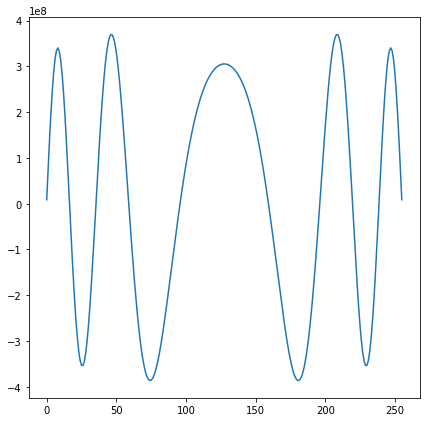

In [31]:
paramAndRanges = [( 'x_1', -apertureRadius, apertureRadius, subdiv_points, 'linear' )]
subsDictC = {'E_0': 1, 'z_1': 2*apertureRadius, 'y_1':0.0, 'x_0': 0, 'y_0': apertureRadius, 'lambda': waveLength, 'a':apertureRadius}
propMethodsCartesian.plotFormula("Rayleigh-Sommerfeld Arg", subsDictC, paramAndRanges, mCalc)